The data scientists at BigMart have collected 2013 sales data for 1559 products across 10 stores in different cities. Also, certain attributes of each product and store have been defined. The aim is to build a predictive model and find out the sales of each product at a particular store.

In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mode
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [2]:
train = pd.read_csv('../Bigmart Sales/train.csv')
test = pd.read_csv('../Bigmart Sales/test.csv')

# Data Exploration

In [3]:
train.shape
test.shape

(5681, 11)

In [4]:
train.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales'],
      dtype='object')

In [5]:
test.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type'],
      dtype='object')

From the data set website (https://datahack.analyticsvidhya.com/contest/practice-problem-big-mart-sales-iii/) we have the following description of the features:

| Variable | Description |
| --- | --- |
| Item_Identifier | Unique product ID | 
| Item_Weight | Weight of product |
| Item_Fat_Content | Whether the product is low fat or not |
| Item_Visibility | The % of total display area of all products in a store allocated to the particular product |
| Item_Type | The category to which the product belongs |
| Item_MRP | Maximum Retail Price (list price) of the product |
| Outlet_Identifier | Unique store ID |
| Outlet_Establishment_Year | The year in which store was established |
| Outlet_Size | The size of the store in terms of ground area covered |
| Outlet_Location_Type | The type of city in which the store is located |
| Outlet_Type | Whether the outlet is just a grocery store or some sort of supermarket |
| Item_Outlet_Sales | Sales of the product in the particulat store. This is the outcome variable to be predicted |


In [6]:
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


Check for missing values:

In [7]:
train.isnull().sum(axis=0)/len(train)*100

Item_Identifier               0.000000
Item_Weight                  17.165317
Item_Fat_Content              0.000000
Item_Visibility               0.000000
Item_Type                     0.000000
Item_MRP                      0.000000
Outlet_Identifier             0.000000
Outlet_Establishment_Year     0.000000
Outlet_Size                  28.276428
Outlet_Location_Type          0.000000
Outlet_Type                   0.000000
Item_Outlet_Sales             0.000000
dtype: float64

In [8]:
test.isnull().sum(axis=0)/len(test)*100

Item_Identifier               0.000000
Item_Weight                  17.180074
Item_Fat_Content              0.000000
Item_Visibility               0.000000
Item_Type                     0.000000
Item_MRP                      0.000000
Outlet_Identifier             0.000000
Outlet_Establishment_Year     0.000000
Outlet_Size                  28.269671
Outlet_Location_Type          0.000000
Outlet_Type                   0.000000
dtype: float64

The only features with missing values in both train and test sets are 'Item_Weight' and 'Outlet_Size'. The percentage missing values are very similar for both set, with 17.17% missing 'Item_Weight' and 28.27% missing 'Outlet_Size'.

Look at the distributions of train and test set:

In [9]:
train.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [10]:
test.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year
count,4705.000000,5681.000000,5681.000000,5681.000000
mean,12.695633,0.065684,141.023273,1997.828903
std,4.664849,0.051252,61.809091,8.372256
min,4.555000,0.000000,31.990000,1985.000000
25%,8.645000,0.027047,94.412000,1987.000000
50%,12.500000,0.054154,141.415400,1999.000000
75%,16.700000,0.093463,186.026600,2004.000000
max,21.350000,0.323637,266.588400,2009.000000


Note that in both sets the minimum of 'Item_Visibility' is 0 which seems to denote missing information. 

Both sets seem to have the same distributions of the quantitative features so we will combine them in order to do the missing values imputation.

In [11]:
train['Src'] = 'train'
test['Src'] = 'test'
data = pd.concat([train, test], ignore_index=True, sort = False)

In [12]:
print(train.shape, test.shape, data.shape)

(8523, 13) (5681, 12) (14204, 13)


In [13]:
data.apply(lambda x: len(x.unique()))

Item_Identifier               1559
Item_Weight                    416
Item_Fat_Content                 5
Item_Visibility              13006
Item_Type                       16
Item_MRP                      8052
Outlet_Identifier               10
Outlet_Establishment_Year        9
Outlet_Size                      4
Outlet_Location_Type             3
Outlet_Type                      4
Item_Outlet_Sales             3494
Src                              2
dtype: int64

As mentioned in the description of the problem, there are 1559 products being sold in 10 stores. 


Explore the frequency of all categorical features:

In [14]:
cat_pred = [x for x in data.dtypes.index if data.dtypes[x] == 'object']
cat_pred = [x for x in cat_pred if x not in ['Item_Identifier', 'Outlet_Identifier','Src']]
for col in cat_pred:
    print('Frequency of the categories in', col)
    print(data[col].value_counts())
    print('')

Frequency of the categories in Item_Fat_Content
Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64

Frequency of the categories in Item_Type
Fruits and Vegetables    2013
Snack Foods              1989
Household                1548
Frozen Foods             1426
Dairy                    1136
Baking Goods             1086
Canned                   1084
Health and Hygiene        858
Meat                      736
Soft Drinks               726
Breads                    416
Hard Drinks               362
Others                    280
Starchy Foods             269
Breakfast                 186
Seafood                    89
Name: Item_Type, dtype: int64

Frequency of the categories in Outlet_Size
Medium    4655
Small     3980
High      1553
Name: Outlet_Size, dtype: int64

Frequency of the categories in Outlet_Location_Type
Tier 3    5583
Tier 2    4641
Tier 1    3980
Name: Outlet_Location_Type, dtype: int64

Frequency of the categ

We see that in the feature 'Item_Fat_Content' we have the category 'Low fat' being coded as both 'Low Fat', 'LF', and 'low fat'. The same happens with the category 'Regular' being coded as both 'Regular' and 'reg'.

Note that some of the categories in 'Item_Type' are non-edible but they still have a specified fat-content. We will try to extract information from 'Item_Identifier' and 'Item_Type'.

Few of the categories in 'Item_Type' have been sold a very little number of times, e.g. 'Seafood', 'Breakfast', Starchy Foods', 'Others', and 'Breads' account for 0.63%, 1.31%, 1.89%, 1.97%, 2.55%, and 2.93%, resp. It might be a good idea to group them together.

We also note that most of the stores are of type 'Supermarket Type1', followed by 'Grocery Store'. The stores of type 'Supermarket Type2' and 'Supermarket Type3' are relatively few compared to 'Supermarket Type1' so we might want to group them together.

# Data Cleaning and Feature Engineering

As already mentioned, the feature 'Item_Fat_Content' is no coded properly so we will correct this:

In [15]:
data['Item_Fat_Content'] = data['Item_Fat_Content'].replace({'LF': 'Low Fat', 
                                                             'low fat': 'Low Fat', 
                                                             'reg': 'Regular'})

Now we will address the missing values of 'Item_Weight' and 'Outlet_Size'. We will impute the missing values in 'Item_Weight' with the average weight of the items in the corresponding 'Item_Type' category.

In [16]:
data['Item_Weight'] = data.groupby('Item_Type')['Item_Weight'].transform(lambda x: x.fillna(x.mean()))

For 'Outlet_Size' we first check the type and the location of the stores:

In [17]:
pd.crosstab( data['Outlet_Type'], data['Outlet_Size'])

Outlet_Size,High,Medium,Small
Outlet_Type,,,
Grocery Store,0,0,880
Supermarket Type1,1553,1550,3100
Supermarket Type2,0,1546,0
Supermarket Type3,0,1559,0


In [18]:
pd.crosstab( data['Outlet_Type'], data['Outlet_Location_Type'])

Outlet_Location_Type,Tier 1,Tier 2,Tier 3
Outlet_Type,,,
Grocery Store,880,0,925
Supermarket Type1,3100,4641,1553
Supermarket Type2,0,0,1546
Supermarket Type3,0,0,1559


We see that all stores of type 'Supermarket Type2' and 'Supermarket Type3' are of medium size and are location is of type 'Tier 3'. Therefore, we will group them together:

In [19]:
data['Outlet_Type'] = data['Outlet_Type'].replace({'Supermarket Type2': 'Supermarket Type2/3',
                                                  'Supermarket Type3': 'Supermarket Type2/3'})

Now we will impute the missing values in 'Outlet_Size' by the mode of 'Outlet_Size' for the corresponding 'Outlet_Type':

In [20]:
pd.crosstab( data['Outlet_Type'], data['Outlet_Size'])

Outlet_Size,High,Medium,Small
Outlet_Type,,,
Grocery Store,0,0,880
Supermarket Type1,1553,1550,3100
Supermarket Type2/3,0,3105,0


In [21]:
mode = (data.groupby('Outlet_Type', as_index=False)
        .agg({'Outlet_Size': lambda x: x.mode()[0]}))
mode

,Outlet_Type,Outlet_Size
0,Grocery Store,Small
1,Supermarket Type1,Small
2,Supermarket Type2/3,Medium


In [22]:
data.loc[(data['Outlet_Type'] == 'Grocery Store') & (data['Outlet_Size'].isnull()), 'Outlet_Size'] = 'Small'
data.loc[(data['Outlet_Type'] == 'Supermarket Type1') & (data['Outlet_Size'].isnull()), 'Outlet_Size'] = 'Small'
data.loc[(data['Outlet_Type'] == 'Supermarket Type2/3') & (data['Outlet_Size'].isnull()), 'Outlet_Size'] = 'Medium'


As already mentioned, 0's in 'Item_Visibility' seem to denote missing values. We will impute this with the average 'Item_Visibility' of the items in the corresponding 'Item_Type' category.

In [23]:
data['Item_Visibility'].replace(0, np.nan, inplace=True)


In [24]:
data['Item_Visibility'] = data.groupby('Item_Type')['Item_Visibility'].transform(lambda x: x.fillna(x.mean()))

Now we deal with the items that are non-edible but still have fat content. As mentioned, we will try to extract information from the 'Item_Identifier' and 'Item_Type'. We note that although each item has a unique 'Item_identifier', 

In [25]:
data.groupby('Item_Type')['Item_Identifier'].unique()

Item_Type
Baking Goods             [FDP36, FDW12, FDC37, FDL12, FDN48, FDR12, FDA...
Breads                   [FDO23, FDV11, FDW11, FDR47, FDZ35, FDV59, FDP...
Breakfast                [FDP49, FDQ49, FDN13, FDN01, FDM25, FDO01, FDM...
Canned                   [FDC14, FDC02, FDL50, FDV49, FDR13, FDI26, FDG...
Dairy                    [FDA15, FDA03, FDU02, FDE51, FDV38, FDM39, FDS...
Frozen Foods             [FDH17, FDU28, FDR28, FDM40, FDY40, FDC29, FDL...
Fruits and Vegetables    [FDX07, FDY07, FDX32, FDF32, FDV20, FDA43, FDM...
Hard Drinks              [DRI11, DRJ59, DRK35, DRG23, DRM47, DRP47, DRQ...
Health and Hygiene       [NCB42, NCS17, NCX29, NCP05, NCL17, NCI17, NCR...
Household                [NCD19, NCB30, NCD06, NCP18, NCX54, NCZ18, NCL...
Meat                     [FDN15, FDK43, FDV27, FDH19, FDN27, FDW39, FDW...
Others                   [NCN07, NCO55, NCM43, NCN55, NCO07, NCM31, NCK...
Seafood                  [FDG33, FDH21, FDG21, FDJ57, FDJ45, FDI57, FDK...
Snack Foods    

All 'Item_Identifier' codes start with 'FD', 'DR' or 'NC' (stand for Food, Drink, Non-consumable?). We will replace the 'Item_Fat_Content' for the non-consumable items by 'DNA' (does not apply). 

In [26]:
data['Item_Identifier_new'] = data['Item_Identifier'].apply(lambda x: x[0:2])

In [27]:
data.groupby('Item_Type')['Item_Identifier_new'].unique()

Item_Type
Baking Goods                 [FD]
Breads                       [FD]
Breakfast                    [FD]
Canned                       [FD]
Dairy                    [FD, DR]
Frozen Foods                 [FD]
Fruits and Vegetables        [FD]
Hard Drinks                  [DR]
Health and Hygiene           [NC]
Household                    [NC]
Meat                         [FD]
Others                       [NC]
Seafood                      [FD]
Snack Foods                  [FD]
Soft Drinks                  [DR]
Starchy Foods                [FD]
Name: Item_Identifier_new, dtype: object

In addition, items of type 'Fruits and Vegetables', 'Hard Drinks', 'Meat', 'Seafood' will also get 'DNA' for 'Item_Fat_Content'.

In [28]:
data.loc[data['Item_Identifier_new'] == 'NC', 'Item_Fat_Content'] = 'DNA'
data.loc[data.Item_Type.isin(['Fruits and Vegetables', 'Hard Drinks', 'Meat', 'Seafood']), 'Item_Fat_Content'] = 'DNA'

From 'Outlet_Establishment_Year' we will define a new variable 'Years_Operation' which is the number of years the respective store had been operating:

In [29]:
data['Years_Operation'] = 2013 - data['Outlet_Establishment_Year']

# One-Hot-Encoding

For building the prediction model we will use the scikit.learn library. Since it only accepts numerical values, first we need to convert all categorical variables into dummy variables. Note that since we need 'Outlet_Identifier' for the submission, we first need to define a new variable for each store and then dummify it.

In [30]:
LE = LabelEncoder()
data['Store'] = LE.fit_transform(data['Outlet_Identifier'])
cat_pred_dummy = ['Item_Fat_Content', 'Item_Type', 'Outlet_Location_Type', 'Outlet_Size', 'Outlet_Type']
data_dummy = data.copy()


for var in cat_pred_dummy:
    data_dummy[var] = LE.fit_transform(data_dummy[var])
    
data_dummy = pd.get_dummies(data_dummy, columns = ['Item_Fat_Content', 'Item_Type', 'Outlet_Location_Type', 
                                        'Outlet_Size', 'Outlet_Type', 'Store'])

# Predictive models

The first step is to split the data set back into train and test sets:

In [31]:
train = data.loc[data['Src'] == 'train']
test = data.loc[data['Src'] == 'test']

train_dummy = data_dummy.loc[data_dummy['Src'] == 'train']
test_dummy = data_dummy.loc[data_dummy['Src'] == 'test']


## Benchmark

We create the benchmark model by predicting the sales as the average sales of product of the same 'Item_Type'.

In [32]:
mean_per_item_type = train.groupby('Item_Type')['Item_Outlet_Sales'].mean()

subm = test[['Item_Identifier', 'Outlet_Identifier']]
subm['Item_Outlet_Sales'] = np.nan
subm['Item_Outlet_Sales'] = data.groupby('Item_Type')['Item_Outlet_Sales'].transform(lambda x: x.fillna(x.mean()))

subm.to_csv("benchmark.csv",index=False)

/home/silvana/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/silvana/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


Public Leaderboard Score: 1775.33583643103

In [33]:
test.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Src,Item_Identifier_new,Years_Operation,Store
8523,FDW58,20.750000,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1,NaN,test,FD,14,9
8524,FDW14,8.300000,Regular,0.038428,Dairy,87.3198,OUT017,2007,Small,Tier 2,Supermarket Type1,NaN,test,FD,6,2
8525,NCN55,14.600000,DNA,0.099575,Others,241.7538,OUT010,1998,Small,Tier 3,Grocery Store,NaN,test,NC,15,0
8526,FDQ58,7.315000,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,Small,Tier 2,Supermarket Type1,NaN,test,FD,6,2
8527,FDY38,13.238358,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type2/3,NaN,test,FD,28,5


In [34]:
subm.head()

,Item_Identifier,Outlet_Identifier,Item_Outlet_Sales
8523,FDW58,OUT049,2277.321739
8524,FDW14,OUT017,2232.542597
8525,NCN55,OUT010,1926.139702
8526,FDQ58,OUT017,2277.321739
8527,FDY38,OUT027,2232.542597


## Linear Regression

In [35]:
pred = [x for x in train_dummy.columns if x not in ['Item_Outlet_Sales','Item_Identifier', 'Outlet_Identifier', 
                                                     'Outlet_Establishment_Year', 'Src', 'Item_Identifier_new']]

In [36]:
lin_regr = LinearRegression(normalize=True)
lin_regr.fit(train_dummy[pred], train_dummy['Item_Outlet_Sales'])
test_dummy['Item_Outlet_Sales'] = lin_regr.predict(test_dummy[pred])

/home/silvana/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [37]:
cv_score = np.sqrt(np.abs(cross_val_score(lin_regr, train_dummy[pred], train_dummy['Item_Outlet_Sales'], 
                cv = 3, scoring='neg_mean_squared_error').mean()))

In [38]:
subm['Item_Outlet_Sales'] = test_dummy['Item_Outlet_Sales']
subm.to_csv('LinearRegression.csv', index = False)

/home/silvana/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Cross-validation score: 1133.7714657463666

Public Leaderboard Score: 1202.84839849882

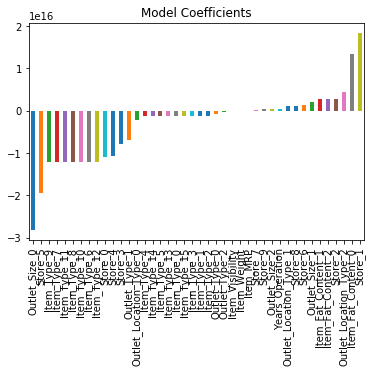

In [39]:
coeff_lin_regr = pd.Series(lin_regr.coef_, pred).sort_values()
coeff_len_regr.plot(kind='bar', title='Model Coefficients')

We see that some of the coefficients are pretty large so we will try to regulize the model by using Ridge and Lasso regression.

## Ridge Regression

In [40]:
ridge_regr = Ridge(alpha=.1, normalize=True)
ridge_regr.fit(train_dummy[pred], train_dummy['Item_Outlet_Sales'])
test_dummy['Item_Outlet_Sales'] = ridge_regr.predict(test_dummy[pred])

/home/silvana/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [41]:
cv_score = np.sqrt(np.abs(cross_val_score(ridge_regr, train_dummy[pred], train_dummy['Item_Outlet_Sales'], 
                cv = 3, scoring='neg_mean_squared_error').mean()))

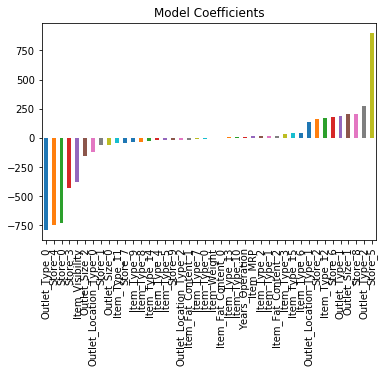

In [42]:
coeff_ridge = pd.Series(ridge_regr.coef_, pred).sort_values()
coeff_ridge.plot(kind='bar', title='Model Coefficients')

In [ ]:
subm['Item_Outlet_Sales'] = test_dummy['Item_Outlet_Sales']
subm.to_csv('RidgeRegression.csv', index = False)

Note that the coefficients now look better but even with a very little regularization parameter alpha (0.1) we still get cross-validation score of 1137.3349089796116 which is not much better than the unregularized model. 

## Lasso Regression

In [43]:
lasso_regr = Lasso(alpha=.1, normalize=True)
lasso_regr.fit(train_dummy[pred], train_dummy['Item_Outlet_Sales'])
test_dummy['Item_Outlet_Sales'] = lasso_regr.predict(test_dummy[pred])

/home/silvana/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [44]:
cv_score = np.sqrt(np.abs(cross_val_score(lasso_regr, train_dummy[pred], train_dummy['Item_Outlet_Sales'], 
                cv = 3, scoring='neg_mean_squared_error').mean()))

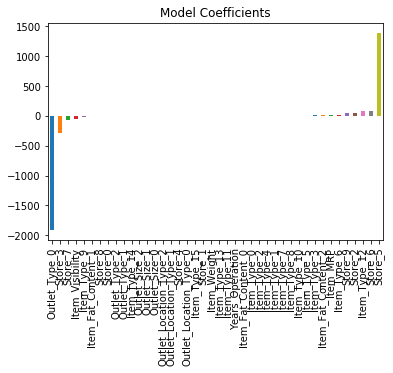

In [45]:
coeff_lasso = pd.Series(lasso_regr.coef_, pred).sort_values()
coeff_lasso.plot(kind='bar', title='Model Coefficients')

In [ ]:
subm['Item_Outlet_Sales'] = test_dummy['Item_Outlet_Sales']
subm.to_csv('LassoRegression.csv', index = False)

The same happens here. Again with small alpha (0.1) we get a cross-validation score of 1131.8868997418629.

## Decision Tree

It seems that the linear models don't fit the data adequately. Now we will fit a decision tree model.

In [102]:
dec_tree = DecisionTreeRegressor(max_depth=6, min_samples_leaf=80)
dec_tree.fit(train_dummy[pred], train_dummy['Item_Outlet_Sales'])
test_dummy['Item_Outlet_Sales'] = dec_tree.predict(test_dummy[pred])

/home/silvana/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [103]:
cv_score = np.sqrt(np.abs(cross_val_score(dec_tree, train_dummy[pred], train_dummy['Item_Outlet_Sales'], 
                cv = 3, scoring='neg_mean_squared_error').mean()))

In [104]:
cv_score

1093.7751907449392

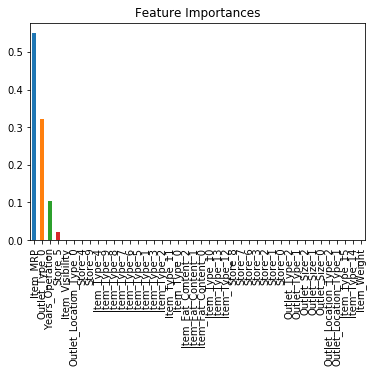

In [105]:
coeff_dec_tree = pd.Series(dec_tree.feature_importances_, pred).sort_values(ascending=False)
coeff_dec_tree.plot(kind='bar', title='Feature Importances')

In [106]:
subm['Item_Outlet_Sales'] = test_dummy['Item_Outlet_Sales']
subm.to_csv('DecisionTree.csv', index = False)

/home/silvana/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Cross-validation score: 1093.7751907449392

Public Leaderboard Score: 1159.26221440279

## Random Forest

In [108]:
random_forest = RandomForestRegressor(n_estimators=200,max_depth=5, min_samples_leaf=100,n_jobs=4)
random_forest.fit(train_dummy[pred], train_dummy['Item_Outlet_Sales'])
test_dummy['Item_Outlet_Sales'] = random_forest.predict(test_dummy[pred])

/home/silvana/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [109]:
cv_score = np.sqrt(np.abs(cross_val_score(random_forest, train_dummy[pred], train_dummy['Item_Outlet_Sales'], 
                cv = 3, scoring='neg_mean_squared_error').mean()))

In [110]:
cv_score

1093.4833737190904

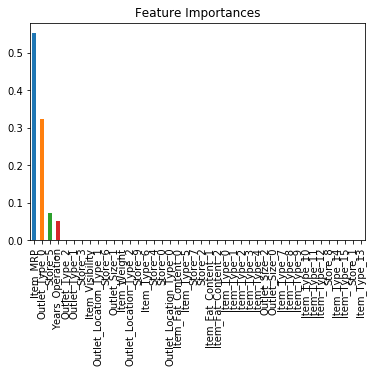

In [111]:
coeff_random_forest = pd.Series(random_forest.feature_importances_, pred).sort_values(ascending=False)
coeff_random_forest.plot(kind='bar', title='Feature Importances')

In [112]:
subm['Item_Outlet_Sales'] = test_dummy['Item_Outlet_Sales']
subm.to_csv('RandomForest.csv', index = False)

/home/silvana/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Cross-validation score: 1093.4833737190904

Public Leaderboard Score: 1153.89144127512

## XGB

In [225]:
import xgboost as xgb
xgb = xgb.XGBRegressor(objective ='reg:linear', learning_rate = 0.4, subsample = 0.8, colsample_bytree = 0.6, 
                min_child_weight = 3, max_depth = 4, n_estimators = 10)
xgb.fit(train_dummy[pred], train_dummy['Item_Outlet_Sales'])
test_dummy['Item_Outlet_Sales'] = xgb.predict(test_dummy[pred])

/home/silvana/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [226]:
cv_score = np.sqrt(np.abs(cross_val_score(xgb, train_dummy[pred], train_dummy['Item_Outlet_Sales'], 
                cv = 3, scoring='neg_mean_squared_error').mean()))

In [227]:
cv_score

1091.031848644131

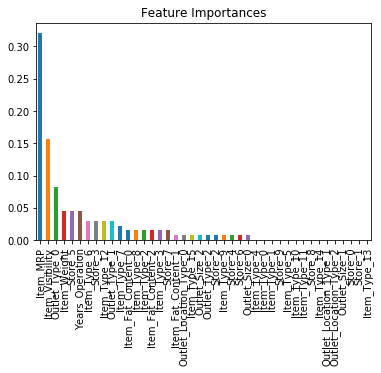

In [228]:
coeff_xgb = pd.Series(xgb.feature_importances_, pred).sort_values(ascending=False)
coeff_xgb.plot(kind='bar', title='Feature Importances')

In [229]:
subm['Item_Outlet_Sales'] = test_dummy['Item_Outlet_Sales']
subm.to_csv('xgb.csv', index = False)

/home/silvana/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Cross-validation score: 1091.031848644131

Public Leaderboard Score: 1156.92198935604


Usually xgb performs better than RandomForest so we need to tune the parameters to improve the performance.

# End Notes

In all cases we get a cross-validation score lower than the actual public leaderboard score which indicates that we are overfitting the data. We might want to revisit the predictors we use. In addition, parameter tuning is required in order to optimize the results.